In [21]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Add project root to path
sys.path.append(os.path.abspath('../../'))

from core.taa.features.pipeline import FeaturePipeline
from core.taa.model_engine import TAAModelEngine
from core.data.collectors import YahooCollector

%matplotlib inline
sns.set_style('whitegrid')

## 1. Load Full Dataset (2010-2024)

In [22]:
# Same setup as 03_model_training
tickers = ['SPY', 'XLK', 'XLE', 'XLF', 'XLV', 'XLI', 'XLP', 'XLY', 'XLU']
benchmark = 'ACWI'

print("Generating features...")
pipeline = FeaturePipeline()
df_features = pipeline.run(
    tickers=tickers,
    benchmark_ticker=benchmark,
    start_date='2010-01-01',
    end_date='2024-12-31'
)

print(f"Features shape: {df_features.shape}")

# Add Close prices for target calculation
yahoo = YahooCollector()
prices_df = yahoo.fetch_history(tickers, '2010-01-01', '2025-12-29')

close_prices = []
for ticker in tickers:
    ticker_prices = prices_df.xs(ticker, axis=1, level=0)['Close']
    ticker_df = pd.DataFrame({'Close': ticker_prices})
    ticker_df['ticker'] = ticker
    ticker_df = ticker_df.reset_index().rename(columns={'index': 'Date'})
    ticker_df = ticker_df.set_index(['Date', 'ticker'])
    close_prices.append(ticker_df)

close_df = pd.concat(close_prices).sort_index()
df_full = df_features.join(close_df, how='left')

# Create targets
engine = TAAModelEngine(horizons=[1, 4, 12])
df_with_targets = engine.create_targets(df_full, price_col='Close')

print(f"Full dataset with targets: {df_with_targets.shape}")

Generating features...
Features shape: (33957, 16)
Features shape: (33957, 16)
Full dataset with targets: (33957, 20)
Full dataset with targets: (33957, 20)


## 2. Define Walk-Forward Folds

Strategy: Expanding window with annual out-of-sample periods
- Fold 1: Train 2010-2014 → Test 2015
- Fold 2: Train 2010-2016 → Test 2017
- Fold 3: Train 2010-2018 → Test 2019
- Fold 4: Train 2010-2020 → Test 2021
- Fold 5: Train 2010-2022 → Test 2023
- Fold 6: Train 2010-2023 → Test 2024

In [23]:
# Define fold boundaries
folds = [
    {'train_end': '2014-12-31', 'test_start': '2015-01-01', 'test_end': '2015-12-31'},
    {'train_end': '2016-12-31', 'test_start': '2017-01-01', 'test_end': '2017-12-31'},
    {'train_end': '2018-12-31', 'test_start': '2019-01-01', 'test_end': '2019-12-31'},
    {'train_end': '2020-12-31', 'test_start': '2021-01-01', 'test_end': '2021-12-31'},
    {'train_end': '2022-12-31', 'test_start': '2023-01-01', 'test_end': '2023-12-31'},
    {'train_end': '2023-12-31', 'test_start': '2024-01-01', 'test_end': '2024-12-31'},
]

print("Walk-Forward Folds:")
for i, fold in enumerate(folds, 1):
    print(f"Fold {i}: Train 2010-{fold['train_end'][:4]} → Test {fold['test_start'][:4]}")

Walk-Forward Folds:
Fold 1: Train 2010-2014 → Test 2015
Fold 2: Train 2010-2016 → Test 2017
Fold 3: Train 2010-2018 → Test 2019
Fold 4: Train 2010-2020 → Test 2021
Fold 5: Train 2010-2022 → Test 2023
Fold 6: Train 2010-2023 → Test 2024


## 3. Run Walk-Forward Validation

In [24]:
import xgboost as xgb

# Prepare feature columns
target_cols = ['target_1w', 'target_4w', 'target_12w']
exclude_cols = target_cols + ['Close', 'Open', 'High', 'Low', 'Volume']
feature_cols = [c for c in df_with_targets.columns if c not in exclude_cols]

print(f"Using {len(feature_cols)} features\n")

# Store results
oos_results = {1: [], 4: [], 12: []}  # Out-of-sample predictions by horizon
fold_metrics = []  # IC metrics per fold

for fold_idx, fold in enumerate(folds, 1):
    print(f"\n{'='*70}")
    print(f"FOLD {fold_idx}: Train through {fold['train_end']}, Test {fold['test_start']} to {fold['test_end']}")
    print('='*70)
    
    # Get dates
    dates = df_with_targets.index.get_level_values('Date')
    train_mask = dates <= fold['train_end']
    test_mask = (dates >= fold['test_start']) & (dates <= fold['test_end'])
    
    train_data = df_with_targets[train_mask]
    test_data = df_with_targets[test_mask]
    
    print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")
    
    fold_ic = {'fold': fold_idx, 'test_year': fold['test_start'][:4]}
    
    # Train models for each horizon
    for horizon in [1, 4, 12]:
        target_col = f'target_{horizon}w'
        pred_col = f'pred_{horizon}w'
        
        # Prepare train data (drop NaNs)
        train_valid = train_data[feature_cols + [target_col]].dropna()
        test_valid = test_data[feature_cols + [target_col]].dropna()
        
        if len(train_valid) == 0 or len(test_valid) == 0:
            print(f"  {horizon}w: Insufficient data, skipping")
            continue
        
        X_train = train_valid[feature_cols]
        y_train = train_valid[target_col]
        X_test = test_valid[feature_cols]
        y_test = test_valid[target_col]
        
        # Train model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            max_depth=5,
            learning_rate=0.05,
            n_estimators=200,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
        
        model.fit(X_train, y_train, verbose=False)
        
        # Predict on test set (truly out-of-sample)
        y_pred = model.predict(X_test)
        
        # Calculate IC
        ic = np.corrcoef(y_test, y_pred)[0, 1]
        
        # Store predictions
        oos_df = pd.DataFrame({
            'date': X_test.index.get_level_values('Date'),
            'ticker': X_test.index.get_level_values('ticker'),
            'actual': y_test.values,
            'predicted': y_pred,
            'fold': fold_idx
        })
        oos_results[horizon].append(oos_df)
        
        # Store IC
        fold_ic[f'ic_{horizon}w'] = ic
        
        print(f"  {horizon}w: IC = {ic:.4f} (Train: {len(X_train)}, Test: {len(X_test)})")
    
    fold_metrics.append(fold_ic)

# Combine all out-of-sample predictions
oos_predictions = {}
for horizon in [1, 4, 12]:
    oos_predictions[horizon] = pd.concat(oos_results[horizon], ignore_index=True)

fold_metrics_df = pd.DataFrame(fold_metrics)
print("\n" + "="*70)
print("Walk-Forward Validation Complete")
print("="*70)

Using 16 features


FOLD 1: Train through 2014-12-31, Test 2015-01-01 to 2015-12-31
Train samples: 11322, Test samples: 2268
  1w: IC = 0.5637 (Train: 9054, Test: 2268)
  1w: IC = 0.5637 (Train: 9054, Test: 2268)
  4w: IC = 0.5268 (Train: 9054, Test: 2268)
  4w: IC = 0.5268 (Train: 9054, Test: 2268)
  12w: IC = 0.2972 (Train: 9054, Test: 2268)

FOLD 2: Train through 2016-12-31, Test 2017-01-01 to 2017-12-31
Train samples: 15858, Test samples: 2259
  12w: IC = 0.2972 (Train: 9054, Test: 2268)

FOLD 2: Train through 2016-12-31, Test 2017-01-01 to 2017-12-31
Train samples: 15858, Test samples: 2259
  1w: IC = 0.1973 (Train: 13590, Test: 2259)
  1w: IC = 0.1973 (Train: 13590, Test: 2259)
  4w: IC = 0.1840 (Train: 13590, Test: 2259)
  4w: IC = 0.1840 (Train: 13590, Test: 2259)
  12w: IC = 0.2795 (Train: 13590, Test: 2259)

FOLD 3: Train through 2018-12-31, Test 2019-01-01 to 2019-12-31
Train samples: 20376, Test samples: 2268
  12w: IC = 0.2795 (Train: 13590, Test: 2259)

FOLD 3: Train thro

## 4. Analyze Out-of-Sample Performance

In [25]:
# Display fold-by-fold IC
print("\nOut-of-Sample IC by Fold:")
display(fold_metrics_df)

# Calculate average IC
print("\nAverage Out-of-Sample IC:")
for horizon in [1, 4, 12]:
    col = f'ic_{horizon}w'
    avg_ic = fold_metrics_df[col].mean()
    std_ic = fold_metrics_df[col].std()
    print(f"{horizon}w: {avg_ic:.4f} ± {std_ic:.4f}")


Out-of-Sample IC by Fold:


,fold,test_year,ic_1w,ic_4w,ic_12w
0,1,2015,0.563723,0.526757,0.297197
1,2,2017,0.197338,0.183980,0.279494
2,3,2019,0.489809,0.647558,0.428311
3,4,2021,0.329899,0.265099,0.229267
4,5,2023,0.425071,0.568859,0.410515
5,6,2024,0.472044,0.309731,0.239677



Average Out-of-Sample IC:
1w: 0.4130 ± 0.1309
4w: 0.4170 ± 0.1882
12w: 0.3141 ± 0.0855


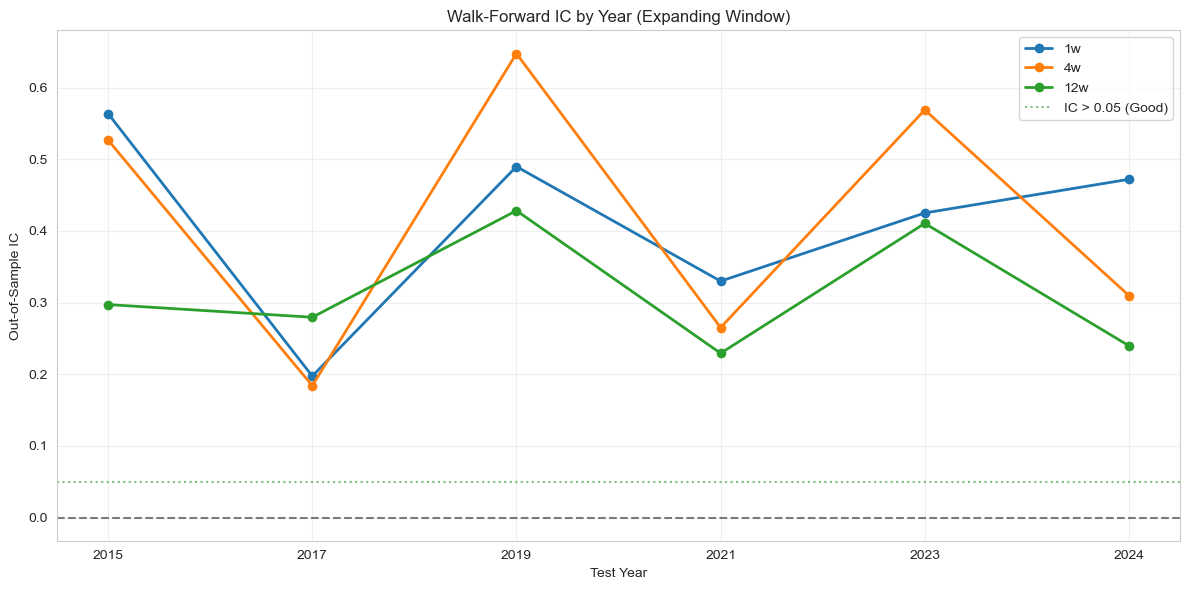

In [26]:
# Plot IC over time
fig, ax = plt.subplots(figsize=(12, 6))

for horizon in [1, 4, 12]:
    col = f'ic_{horizon}w'
    ax.plot(fold_metrics_df['test_year'], fold_metrics_df[col], 
            marker='o', label=f'{horizon}w', linewidth=2)

ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.axhline(0.05, color='green', linestyle=':', alpha=0.5, label='IC > 0.05 (Good)')
ax.set_xlabel('Test Year')
ax.set_ylabel('Out-of-Sample IC')
ax.set_title('Walk-Forward IC by Year (Expanding Window)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Calculate Hit Rate (Directional Accuracy)

In [27]:
print("Hit Rate Analysis (% Correct Direction):\n")

for horizon in [1, 4, 12]:
    df = oos_predictions[horizon]
    
    # Calculate directional accuracy
    correct_direction = np.sign(df['actual']) == np.sign(df['predicted'])
    hit_rate = correct_direction.mean()
    
    # Overall IC
    overall_ic = np.corrcoef(df['actual'], df['predicted'])[0, 1]
    
    print(f"{horizon}w Horizon:")
    print(f"  Hit Rate: {hit_rate:.2%}")
    print(f"  Overall IC: {overall_ic:.4f}")
    print(f"  Samples: {len(df)}")
    print()

Hit Rate Analysis (% Correct Direction):

1w Horizon:
  Hit Rate: 65.52%
  Overall IC: 0.4295
  Samples: 13567

4w Horizon:
  Hit Rate: 69.35%
  Overall IC: 0.4204
  Samples: 13552

12w Horizon:
  Hit Rate: 73.43%
  Overall IC: 0.2758
  Samples: 13512



## 6. Quintile Analysis

Compare actual returns for top 20% predictions vs bottom 20%

In [28]:
print("Quintile Analysis (Top 20% vs Bottom 20% Predictions):\n")

for horizon in [1, 4, 12]:
    df = oos_predictions[horizon].copy()
    
    # Sort by predictions
    df = df.sort_values('predicted')
    
    # Get top and bottom quintiles
    n = len(df)
    quintile_size = n // 5
    
    bottom_quintile = df.head(quintile_size)['actual'].mean()
    top_quintile = df.tail(quintile_size)['actual'].mean()
    spread = top_quintile - bottom_quintile
    
    print(f"{horizon}w Horizon:")
    print(f"  Bottom 20% avg actual return: {bottom_quintile:+.4f}")
    print(f"  Top 20% avg actual return: {top_quintile:+.4f}")
    print(f"  Spread (Top - Bottom): {spread:+.4f}")
    print()

Quintile Analysis (Top 20% vs Bottom 20% Predictions):

1w Horizon:
  Bottom 20% avg actual return: -0.0099
  Top 20% avg actual return: +0.0147
  Spread (Top - Bottom): +0.0246

4w Horizon:
  Bottom 20% avg actual return: -0.0124
  Top 20% avg actual return: +0.0355
  Spread (Top - Bottom): +0.0479

12w Horizon:
  Bottom 20% avg actual return: +0.0205
  Top 20% avg actual return: +0.0705
  Spread (Top - Bottom): +0.0500



## 7. Decision: Proceed to Portfolio Construction?

**Criteria for Success:**
- ✅ Average OOS IC > 0.05 for at least one horizon
- ✅ IC relatively stable (not declining over time)
- ✅ Hit Rate > 52%
- ✅ Positive quintile spread

In [29]:
# Automated decision logic
print("\n" + "="*70)
print("MODEL VALIDATION DECISION")
print("="*70 + "\n")

checks = []

# Check 1: IC > 0.05
for horizon in [1, 4, 12]:
    avg_ic = fold_metrics_df[f'ic_{horizon}w'].mean()
    if avg_ic > 0.05:
        checks.append(f"✅ {horizon}w IC = {avg_ic:.4f} > 0.05")
        break
else:
    checks.append("❌ No horizon has IC > 0.05")

# Check 2: Hit rate
for horizon in [1, 4, 12]:
    df = oos_predictions[horizon]
    hit_rate = (np.sign(df['actual']) == np.sign(df['predicted'])).mean()
    if hit_rate > 0.52:
        checks.append(f"✅ {horizon}w Hit Rate = {hit_rate:.2%} > 52%")
        break
else:
    checks.append("❌ No horizon has hit rate > 52%")

# Check 3: IC stability (coefficient of variation)
for horizon in [1, 4, 12]:
    col = f'ic_{horizon}w'
    cv = fold_metrics_df[col].std() / abs(fold_metrics_df[col].mean())
    if cv < 1.0:  # CV < 1 means relatively stable
        checks.append(f"✅ {horizon}w IC stable (CV = {cv:.2f})")
        break
else:
    checks.append("⚠️  IC shows high variability across folds")

for check in checks:
    print(check)

# Final verdict
if all('✅' in check for check in checks):
    print("\n🎉 MODEL PASSED VALIDATION - Proceed to Portfolio Construction")
elif any('✅' in check for check in checks):
    print("\n⚠️  MODEL PARTIALLY VALIDATED - Proceed with caution or improve features")
else:
    print("\n❌ MODEL FAILED VALIDATION - Do not proceed, improve model first")


MODEL VALIDATION DECISION

✅ 1w IC = 0.4130 > 0.05
✅ 1w Hit Rate = 65.52% > 52%
✅ 1w IC stable (CV = 0.32)

🎉 MODEL PASSED VALIDATION - Proceed to Portfolio Construction


## 8. Save Out-of-Sample Predictions for Portfolio Construction

In [30]:
# Save OOS predictions to CSV for portfolio backtest
output_dir = '../../data/taa/'
os.makedirs(output_dir, exist_ok=True)

for horizon in [1, 4, 12]:
    filepath = f'{output_dir}oos_predictions_{horizon}w.csv'
    oos_predictions[horizon].to_csv(filepath, index=False)
    print(f"Saved: {filepath}")

print("\n✅ Out-of-sample predictions saved for portfolio construction")

Saved: ../../data/taa/oos_predictions_1w.csv
Saved: ../../data/taa/oos_predictions_4w.csv
Saved: ../../data/taa/oos_predictions_12w.csv

✅ Out-of-sample predictions saved for portfolio construction
